In [1]:
#Keras library for CIFAR dataset
from keras.datasets import cifar10

#Downloading the CIFAR dataset
(x_train,y_train),(x_test,y_test)=cifar10.load_data()
#importing other required libraries
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.utils import to_categorical

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
#Train-validation-test split
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

#Dimension of the CIFAR10 dataset
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((24500, 32, 32, 3), (24500, 1))
((10500, 32, 32, 3), (10500, 1))
((10000, 32, 32, 3), (10000, 1))


In [4]:
#Onehot Encoding the labels.
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.utils import to_categorical

#Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

#Verifying the dimension after one hot encoding
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((24500, 32, 32, 3), (24500, 10))
((10500, 32, 32, 3), (10500, 10))
((10000, 32, 32, 3), (10000, 10))


In [5]:
#Image Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1 )

val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1)

test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True,zoom_range=.1)

#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [6]:
#Learning Rate Annealer
from keras.callbacks import ReduceLROnPlateau
lrr= ReduceLROnPlateau(   monitor='val_acc',   factor=.01,   patience=3,  min_lr=1e-5)

In [7]:
!pip install keras_efficientnets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from tensorflow.keras.applications.efficientnet import EfficientNetB5

In [17]:
#Defining the model
base_model = EfficientNetB5(include_top=False, weights="imagenet", input_shape=(32,32,3),classes=y_train.shape[1])

#Adding the final layers to the above base models where the actual classification is done in the dense layers

model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

#Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 1, 1, 1408)       7768569   
                                                                 
 flatten_1 (Flatten)         (None, 1408)              0         
                                                                 
Total params: 7,768,569
Trainable params: 7,700,994
Non-trainable params: 67,575
_________________________________________________________________


In [18]:
#Adding the Dense layers along with activation and batch normalization
model.add(Dense(1024,activation=('relu'),input_dim=512))

model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
#model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model.add(Dense(10,activation=('softmax'))) 

#Checking the final model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 1, 1, 1408)       7768569   
                                                                 
 flatten_1 (Flatten)         (None, 1408)              0         
                                                                 
 dense_5 (Dense)             (None, 1024)              1442816   
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 10)               

In [19]:
#Defining the parameters
batch_size= 100
epochs=4
learn_rate=.001

In [20]:
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [21]:
#Compiling the model
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

#Training the model
model.fit_generator(train_generator.flow(x_train, y_train, batch_size = batch_size), epochs = epochs, steps_per_epoch = x_train.shape[0]//batch_size, validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size), validation_steps = 250,  callbacks = [lrr], verbose = 1)

Epoch 1/4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


245/245 [==============================] - 505s 2s/step - loss: 2.2878 - accuracy: 0.1383 - val_loss: 2.2403 - val_accuracy: 0.2068 - lr: 0.0010
Epoch 2/4
245/245 [==============================] - 453s 2s/step - loss: 2.1101 - accuracy: 0.2611 - lr: 0.0010
Epoch 3/4
245/245 [==============================] - 443s 2s/step - loss: 1.7236 - accuracy: 0.3884 - lr: 0.0010
Epoch 4/4
245/245 [==============================] - 462s 2s/step - loss: 1.4436 - accuracy: 0.4802 - lr: 0.0010


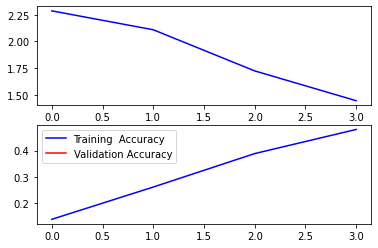

In [22]:
import matplotlib.pyplot as plt
#Plotting the training and validation loss

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

In [23]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

In [24]:
#Making prediction
y_p=model.predict(x_test)
y_pred=np.argmax(y_p,axis=1)
y_true=np.argmax(y_test,axis=1)

Confusion matrix, without normalization


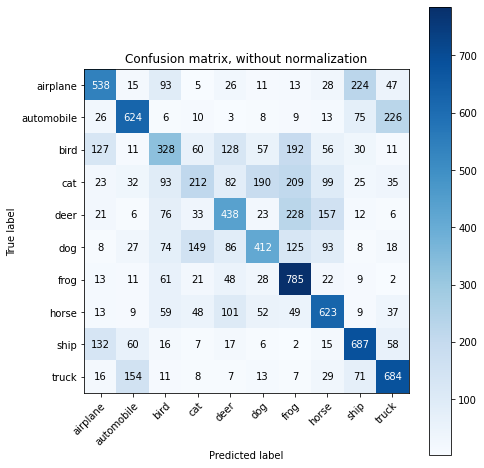

In [25]:
from sklearn.metrics import confusion_matrix
#Plotting the confusion matrix

confusion_mtx=confusion_matrix(y_true,y_pred)
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names,title = 'Confusion matrix, without normalization')

Normalized confusion matrix


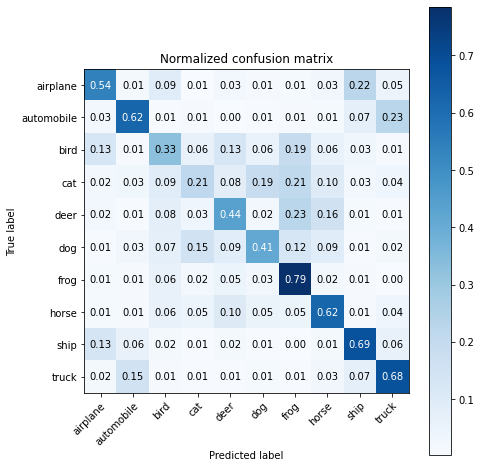

In [26]:
# Plotting normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')

In [27]:
#The average accuracy score in classifying the unseen test data will be obtained now.

#Classification accuracy
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_true, y_pred)
print('Accuracy Score = ', acc_score)

Accuracy Score =  0.5331
